# HOAX

**PREDICTIVE MODEL TO CHECK REPORTS OF ENVIRONMENTAL ACCIDENTS**

Data is being retrieved from the database, including reports of environmental accidents managed by IBAMA from Siema. This project proposes the development of a system to validate reports of environmental accidents, with the goal of preventing the misuse of public resources.

## SETTING THE ENVIRONMENT

Importing the pertinent libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.svm  import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree

from keras import optimizers, \
                  regularizers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.callbacks import EarlyStopping

Auxiliary functions:

In [2]:
def is_str(data):
    return 1 if pd.notna(data) and data != "Não há descrição" else 0

def first_str(data):
    return data.split(';')[0]

def count_str(data):
    return len(data.split(';')) if pd.notna(data) else 0

## DATA PROCESSING

Loading data directly from the [Portal de Dados Abertos](https://dados.gov.br/):

In [3]:
file = 'data/acidenteambiental.csv'
url  = 'http://siscom.ibama.gov.br/geoserver/publica/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=publica:adm_comunicacidente_p&outputFormat=csv'

cols = [
    'institiuicoes_atuando_local', 'iniciados_outras_providencias', 'origem',
    'plano_emergencia_acionado', 'informacao_responsavel', 'ocorrencia_oleo',
    'informacao_geografica', 'tipos_fontes_informacoes', 'des_ocorrencia',
    'uf', 'tipos_danos_identificados', 'periodo_ocorrencia', 'validado'
]

notifications = pd.read_csv(url, low_memory=False, usecols=cols)[cols]
notifications.head()

,institiuicoes_atuando_local,iniciados_outras_providencias,origem,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,tipos_fontes_informacoes,des_ocorrencia,uf,tipos_danos_identificados,periodo_ocorrencia,validado
0,Corpo de Bombeiros;Polícia Rodoviária,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de biocombust...,AL,Óbitos/feridos,M,S
1,Corpo de Bombeiros,N,Armazenamento/depósito,N,N,N,S,Mídia,Explosão em depósito de gás.,ES,Outro(s),M,S
2,Outra(s),N,Outro(s),N,N,N,S,Mídia,Vazamento de esgoto em grande quantidade causa...,MS,Fauna;Flora;População afetada/evacuada;Rio/cór...,M,S
3,Corpo de Bombeiros;Defesa Civil,N,Rodovia,N,N,N,S,Mídia,Tombamento de caminhão carregado de combustíve...,DF,Solo,M,S
4,Outra(s),N,Outro(s),N,N,N,S,Mídia,300 Kg de produtos poluidores encontrados ás m...,RS,Rio/córrego;Solo,M,S


Checking data information:

In [4]:
notifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13755 entries, 0 to 13754
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   institiuicoes_atuando_local    12096 non-null  object
 1   iniciados_outras_providencias  13755 non-null  object
 2   origem                         13582 non-null  object
 3   plano_emergencia_acionado      13755 non-null  object
 4   informacao_responsavel         13755 non-null  object
 5   ocorrencia_oleo                13755 non-null  object
 6   informacao_geografica          6861 non-null   object
 7   tipos_fontes_informacoes       13412 non-null  object
 8   des_ocorrencia                 5775 non-null   object
 9   uf                             12802 non-null  object
 10  tipos_danos_identificados      12814 non-null  object
 11  periodo_ocorrencia             12962 non-null  object
 12  validado                       13755 non-null  object
dtypes

An initial look at the dataframe allows observing the lack of uniformity in the treatment of boolean data:

```
plano_emergencia_acionado     -> [  N, S]
iniciados_outras_providencias -> [  N, S]
ocorrencia_oleo               -> [  N, S]
informacao_geografica         -> [nan, S]
informacao_responsavel        -> [  N, T]
validado                      -> [  N, S]
```

In [5]:
notifications.plano_emergencia_acionado = notifications.plano_emergencia_acionado.map({'N' : 0,
                                                                                       'S' : 1})

notifications.plano_emergencia_acionado

0        0
1        0
2        0
3        0
4        0
        ..
13750    1
13751    0
13752    0
13753    0
13754    0
Name: plano_emergencia_acionado, Length: 13755, dtype: int64

In [6]:
notifications.iniciados_outras_providencias = notifications.iniciados_outras_providencias.map({'N' : 0,
                                                                                               'S' : 1})

notifications.iniciados_outras_providencias

0        0
1        0
2        0
3        0
4        0
        ..
13750    0
13751    1
13752    1
13753    1
13754    1
Name: iniciados_outras_providencias, Length: 13755, dtype: int64

In [7]:
notifications.ocorrencia_oleo = notifications.ocorrencia_oleo.map({'N' : 0,
                                                                   'S' : 1})

notifications.ocorrencia_oleo

0        0
1        0
2        0
3        0
4        0
        ..
13750    1
13751    1
13752    1
13753    1
13754    0
Name: ocorrencia_oleo, Length: 13755, dtype: int64

In [8]:
notifications.informacao_geografica = notifications.informacao_geografica.map({np.nan : 0,
                                                                               'S'    : 1})

notifications.informacao_geografica

0        1
1        1
2        1
3        1
4        1
        ..
13750    0
13751    0
13752    0
13753    0
13754    0
Name: informacao_geografica, Length: 13755, dtype: int64

In [9]:
notifications.informacao_responsavel = notifications.informacao_responsavel.map({'N' : 0,
                                                                                 'T' : 1})

notifications.informacao_responsavel

0        0
1        0
2        0
3        0
4        0
        ..
13750    1
13751    1
13752    1
13753    1
13754    1
Name: informacao_responsavel, Length: 13755, dtype: int64

In [10]:
notifications.validado = notifications.validado.map({'N' : 0,
                                                     'S' : 1})

notifications.validado

0        1
1        1
2        1
3        1
4        1
        ..
13750    0
13751    1
13752    1
13753    1
13754    1
Name: validado, Length: 13755, dtype: int64

Get the information if it has a description or not:

In [11]:
notifications.des_ocorrencia = notifications.des_ocorrencia.apply(is_str)

notifications.des_ocorrencia.value_counts()

des_ocorrencia
0    7982
1    5773
Name: count, dtype: int64

Applying the `OneHotEncoder` strategy:

In [12]:
notifications.dropna(subset=['periodo_ocorrencia'], inplace=True)

ohe_per = OneHotEncoder(sparse_output=False)
encoded = ohe_per.fit_transform(notifications[['periodo_ocorrencia']])
encoded = pd.DataFrame(encoded, columns=ohe_per.get_feature_names_out(['periodo_ocorrencia']))

notifications.drop(columns=['periodo_ocorrencia'], inplace=True)
notifications = pd.concat([notifications.reset_index(drop=True), encoded], axis=1)

for col in encoded.columns:
    count = encoded[col].sum()
    encod = [[int(c == col) for c in encoded.columns]]
    label = ohe_per.inverse_transform(encod)[0][0]

    print(f'{col} ({label} - {encod}) -> {int(count)}')

periodo_ocorrencia_M (M - [[1, 0, 0, 0]]) -> 8384
periodo_ocorrencia_N (N - [[0, 1, 0, 0]]) -> 1166
periodo_ocorrencia_S (S - [[0, 0, 1, 0]]) -> 1104
periodo_ocorrencia_V (V - [[0, 0, 0, 1]]) -> 2308


In [13]:
notifications.dropna(subset=['uf'], inplace=True)

ohe_uf  = OneHotEncoder(sparse_output=False)
encoded = ohe_uf.fit_transform(notifications[['uf']])
encoded = pd.DataFrame(encoded, columns=ohe_uf.get_feature_names_out(['uf']))

notifications.drop(columns=['uf'], inplace=True)
notifications = pd.concat([notifications.reset_index(drop=True), encoded], axis=1)

for col in encoded.columns:
    count = encoded[col].sum()
    encod = [[int(c == col) for c in encoded.columns]]
    label = ohe_uf.inverse_transform(encod)[0][0]

    print(f'{col} ({label} - {encod}) -> {int(count)}')

uf_AC (AC - [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 5
uf_AL (AL - [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 126
uf_AM (AM - [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 127
uf_AP (AP - [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 12
uf_BA (BA - [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 483
uf_CE (CE - [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 182
uf_DF (DF - [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 139
uf_ES (ES - [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 393
uf_GO (GO - [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 192
uf_MA (MA - [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

Getting first origin description, taking into account the assumption that a hierarchical order exists within the classification system:

In [14]:
notifications.dropna(subset=['origem'], inplace=True)

notifications['origem'] = notifications['origem'].apply(first_str)

ohe_org = OneHotEncoder(sparse_output=False)
encoded = ohe_org.fit_transform(notifications[['origem']])
encoded = pd.DataFrame(encoded, columns=ohe_org.get_feature_names_out(['origem']))

notifications.drop(columns=['origem'], inplace=True)
notifications = pd.concat([notifications.reset_index(drop=True), encoded], axis=1)

for col in encoded.columns:
    count = encoded[col].sum()
    encod = [[int(c == col) for c in encoded.columns]]
    label = ohe_org.inverse_transform(encod)[0][0]

    print(f'{col:<40} ({label:<32} - {encod}) -> {int(count)}')

origem_Armazenamento/depósito            (Armazenamento/depósito           - [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 215
origem_Barragem                          (Barragem                         - [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 145
origem_Duto                              (Duto                             - [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 629
origem_Embarcação                        (Embarcação                       - [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]) -> 811
origem_Ferrovia                          (Ferrovia                         - [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]) -> 1172
origem_Indústria                         (Indústria                        - [[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]) -> 822
origem_Outro(s)                          (Outro(s)                         - [[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]) -> 2035
origem_Plataforma                        (Plataforma                       - [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]) -> 1415
orige

We obtain relevant information on how many institutions are operating in the area:

In [15]:
notifications.institiuicoes_atuando_local = notifications.institiuicoes_atuando_local.apply(count_str)

notifications.rename(columns={'institiuicoes_atuando_local' : 'quant_instituicoes_atuando_local'}, inplace=True)

notifications.quant_instituicoes_atuando_local

0        2
1        1
2        1
3        2
4        1
        ..
11988    1
11989    1
11990    1
11991    1
11992    1
Name: quant_instituicoes_atuando_local, Length: 11993, dtype: int64

Same strategy as column `institiuicoes_atuando_local`:

In [16]:
notifications.tipos_fontes_informacoes = notifications.tipos_fontes_informacoes.apply(count_str)

notifications.rename(columns={'tipos_fontes_informacoes' : 'quant_fontes_informacoes'}, inplace=True)

notifications.quant_fontes_informacoes

0        1
1        1
2        1
3        1
4        1
        ..
11988    1
11989    1
11990    1
11991    1
11992    1
Name: quant_fontes_informacoes, Length: 11993, dtype: int64

Same strategy as column `institiuicoes_atuando_local`:

In [17]:
notifications.tipos_danos_identificados = notifications.tipos_danos_identificados.apply(count_str)

notifications.rename(columns={'tipos_danos_identificados' : 'quant_tipos_danos_identificados'}, inplace=True)

notifications.quant_tipos_danos_identificados

0        1
1        1
2        4
3        1
4        2
        ..
11988    1
11989    1
11990    1
11991    1
11992    1
Name: quant_tipos_danos_identificados, Length: 11993, dtype: int64

## EXPLORATORY DATA ANALISYS

Database obtained after pre-processing:

In [18]:
notifications.head()

,quant_instituicoes_atuando_local,iniciados_outras_providencias,plano_emergencia_acionado,informacao_responsavel,ocorrencia_oleo,informacao_geografica,quant_fontes_informacoes,des_ocorrencia,quant_tipos_danos_identificados,validado,...,origem_Duto,origem_Embarcação,origem_Ferrovia,origem_Indústria,origem_Outro(s),origem_Plataforma,origem_Posto de combustível,origem_Refinaria,origem_Rodovia,origem_Terminal/portos/ancoradouros/etc
0,2,0,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,1,1,1,4,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,0,0,0,0,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,0,0,0,0,1,1,1,2,1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Checking the distribution of validated occurrences:

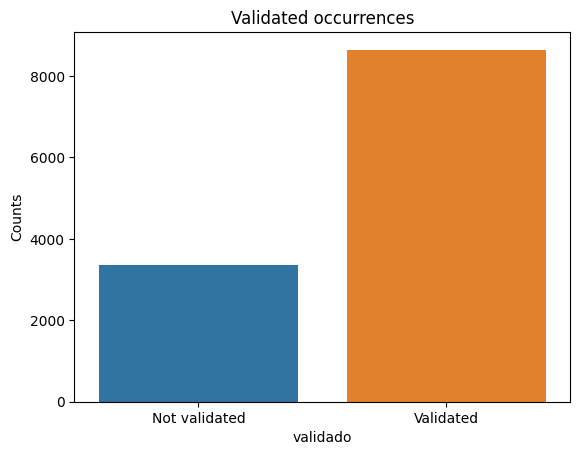

In [19]:
sns.countplot(x=notifications.validado)

plt.title("Validated occurrences")
plt.xticks(ticks=[0, 1], labels=["Not validated", "Validated"])
plt.ylabel("Counts")

plt.show()

Checking attribute distribution:

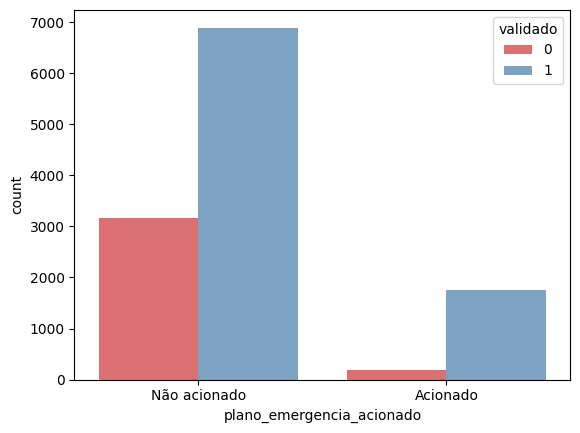

In [20]:
sns.countplot(data=notifications, x="plano_emergencia_acionado",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não acionado", "Acionado"])

plt.show()

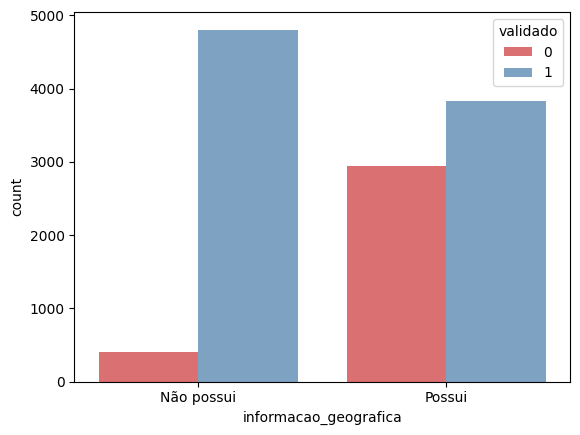

In [21]:
sns.countplot(data=notifications, x="informacao_geografica",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

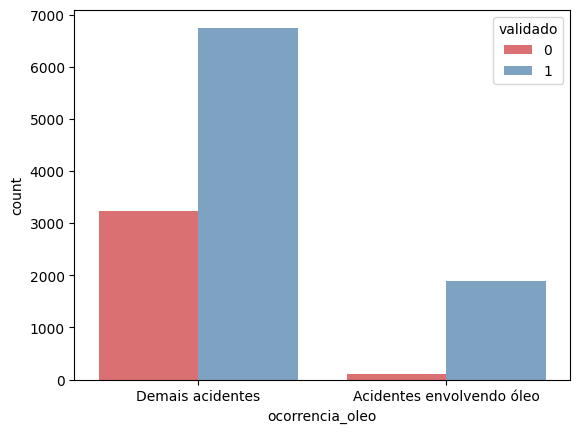

In [22]:
sns.countplot(data=notifications, x="ocorrencia_oleo",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Demais acidentes", "Acidentes envolvendo óleo"])

plt.show()

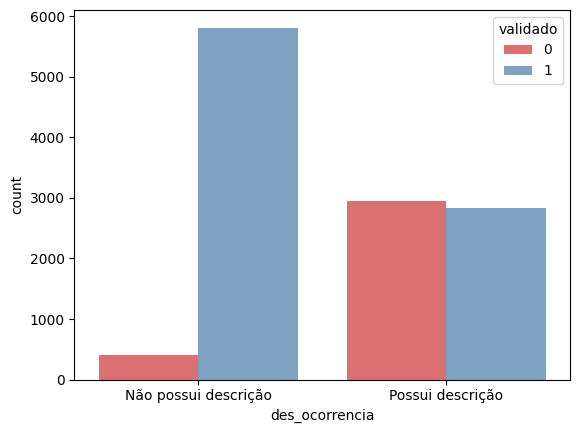

In [23]:
sns.countplot(data=notifications, x="des_ocorrencia",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui descrição", "Possui descrição"])

plt.show()

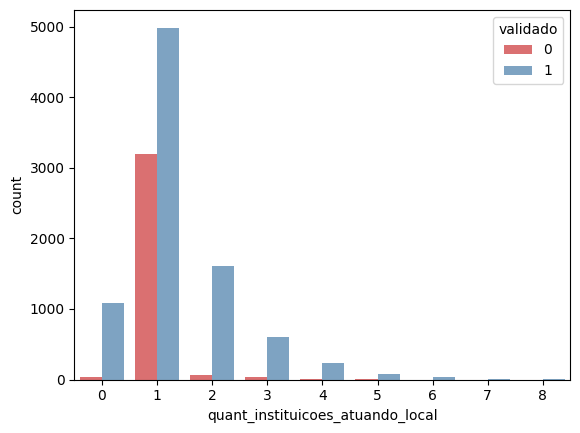

In [24]:
sns.countplot(data=notifications, x="quant_instituicoes_atuando_local",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

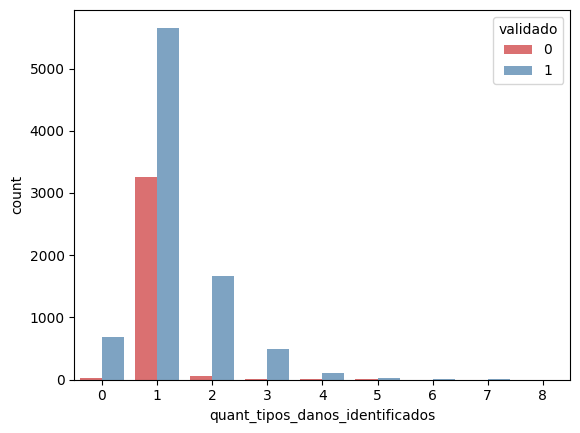

In [25]:
sns.countplot(data=notifications, x="quant_tipos_danos_identificados",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

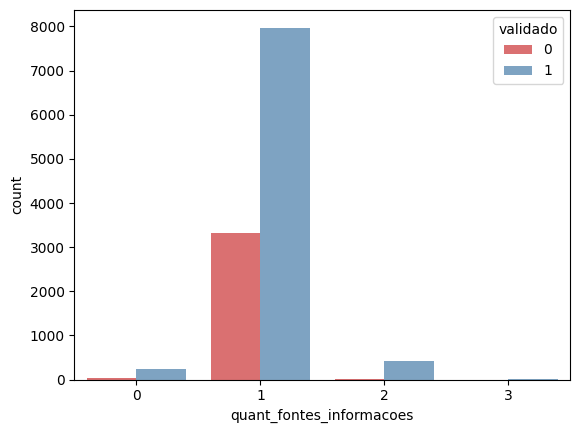

In [26]:
sns.countplot(data=notifications, x="quant_fontes_informacoes",
              hue="validado", palette='Set1', alpha =.7)

plt.show()

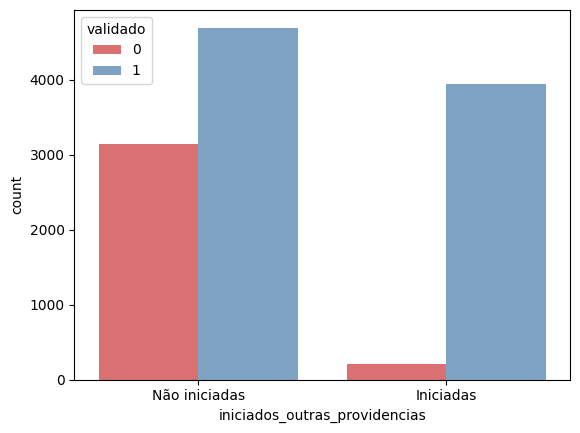

In [27]:
sns.countplot(data=notifications, x="iniciados_outras_providencias",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não iniciadas", "Iniciadas"])

plt.show()

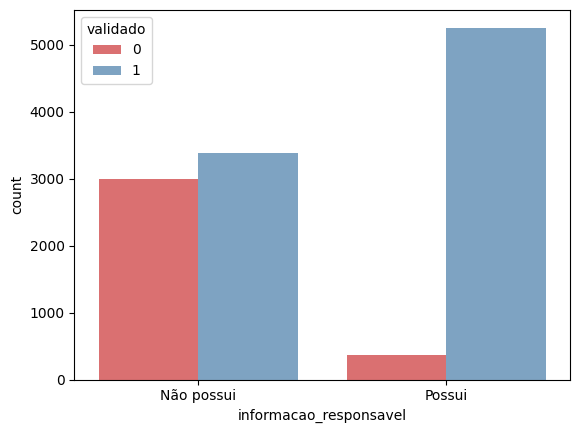

In [28]:
sns.countplot(data=notifications, x="informacao_responsavel",
              hue="validado", palette='Set1', alpha =.7)
plt.xticks([0, 1], ["Não possui", "Possui"])

plt.show()

Checking the correlation matrix:

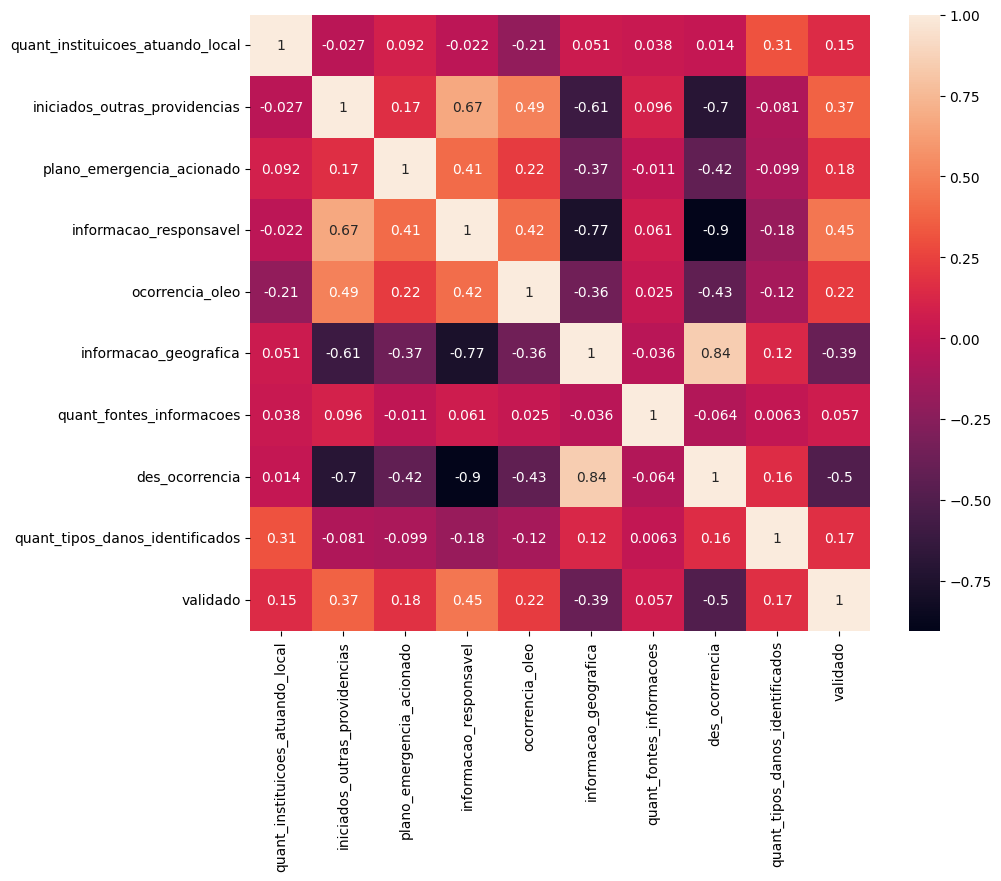

In [29]:
plt.figure(figsize=(10, 8))

cols_corr = notifications.columns[:10]

corr = notifications[cols_corr].corr()
sns.heatmap(corr, annot=True)

plt.show()

## DATA PROCESSING FOR ML MODELS

Building the inputs for the classifier:

> **Note**: It was not considered necessary to normalize or standardize the data.

In [30]:
X = notifications.drop(["validado"], axis=1).to_numpy()
y = notifications["validado"].to_numpy()

N, p = X.shape

print("Number of samples:", N)
print("Number of parameters:", p)

Number of samples: 11993
Number of parameters: 52


Separating data between training and testing:
- The decision to split the data before all classifiers is to ensure that all classifiers train on the same data
- N obtained by the golden rule applied to each of the models will allow us to use 30% of the data for testing

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

N_train, N_test = X_train.shape[0], X_test.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in the test:", N_test)

Number of samples in training: 8395
Number of samples in the test: 3598


## DTC

Getting the VC dimension for decision trees:

> **Note**: As the training set has size 8395 the golden rule is satisfied.

In [32]:
summ = sum(2**(len(notifications[col].unique()) - 1)
           for col in notifications)

d_vc = int(np.log(summ + 1) + 1)

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 7
By the golden rule: N >= 70


Building a decision tree with the training instance:

In [33]:
clf_tree = DecisionTreeClassifier()

clf_tree.fit(X_train, y_train)

DecisionTreeClassifier()

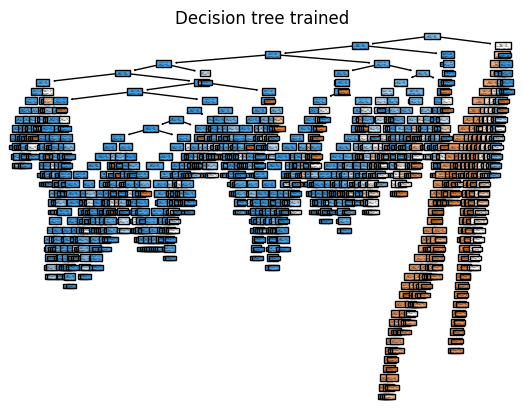

In [34]:
plot_tree(clf_tree, filled=True)
plt.title("Decision tree trained")

plt.show()

Computing `𝐸𝑖𝑛` and `𝐸𝑜𝑢𝑡` to analyze for overfitting:
- The results obtained allow us to infer that there was no overfitting
- The difference between Ein and Eout was low (less than 5%)

In [35]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Ein = {(1 - clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=1'],
                   columns=['h(x)=0', 'h(x)=1']))

print()
print(classification_report(y_test, clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Ein = 9.26%
Eout = 12.76%

        h(x)=0  h(x)=1
f(x)=0     892     106
f(x)=1     353    2247

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       998
           1       0.95      0.86      0.91      2600

    accuracy                           0.87      3598
   macro avg       0.84      0.88      0.85      3598
weighted avg       0.89      0.87      0.88      3598



Regularizing the value of 𝛼 using the Minimal Cost-Complexity algorithm, the golden rule, where $K = \frac{N}{5}$​, is applied in this process.

In [36]:
clf = DecisionTreeClassifier()
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

param_grid = {'ccp_alpha' : ccp_alphas[ccp_alphas > 0]}

CV_clf_tree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
CV_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([3.82986972e-09, 4.07544698e-08, 4.84812873e-08, 9.02413053e-08,
       9.32069819e-08, 1.23226058e-07, 1.77523879e-07, 2.73835685e-07,
       3.97061743e-07, 5.37607776e-07, 5.67231062e-07, 6.63844085e-07,
       6.98130537e-07, 7.05887543e-07, 7.78552437e-07, 8.27211965e-07,
       8.82359429e-07, 9.92654358e...
       2.06443774e-04, 2.10613804e-04, 2.13247146e-04, 2.16504579e-04,
       2.23127659e-04, 2.27458170e-04, 2.29728580e-04, 2.30449351e-04,
       2.35773579e-04, 2.65668891e-04, 2.88404710e-04, 2.94130135e-04,
       2.95371726e-04, 3.45477061e-04, 4.02671543e-04, 5.73418322e-04,
       6.04008529e-04, 6.09165185e-04, 8.67639761e-04, 1.79099831e-03,
       2.38603204e-03, 2.73072268e-03, 3.69578752e-03, 5.28470792e-03,
       4.25319539e-02, 7.47196932e-02, 9.82374451e-02])})

In [37]:
results = pd.DataFrame(CV_clf_tree.cv_results_)
results = results.sort_values(by=["rank_test_score"])
results = results.set_index(results["params"].apply(lambda x: x['ccp_alpha']))

results[["mean_test_score", "std_test_score"]]

,mean_test_score,std_test_score
params,,
0.002731,0.891126,0.006507
0.000573,0.891126,0.006507
0.002386,0.891126,0.006507
0.000604,0.891126,0.006507
0.001791,0.891126,0.006507
...,...,...
0.000001,0.861584,0.009061
0.000004,0.861465,0.010063
0.042532,0.855390,0.023640


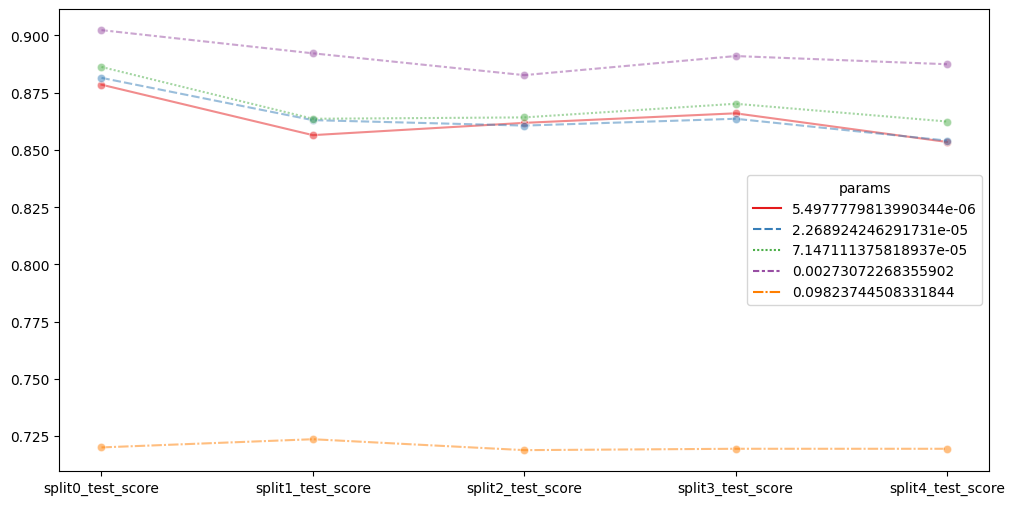

In [38]:
plt.figure(figsize=(12, 6))

sns.lineplot(data=results.transpose().iloc[6:11, np.linspace(0, results.shape[0]-1, 5, dtype='int64')],
             palette="Set1", marker="o", alpha=0.5)

plt.show()

Plotting the tree and computing the quality metrics of the best built tree:

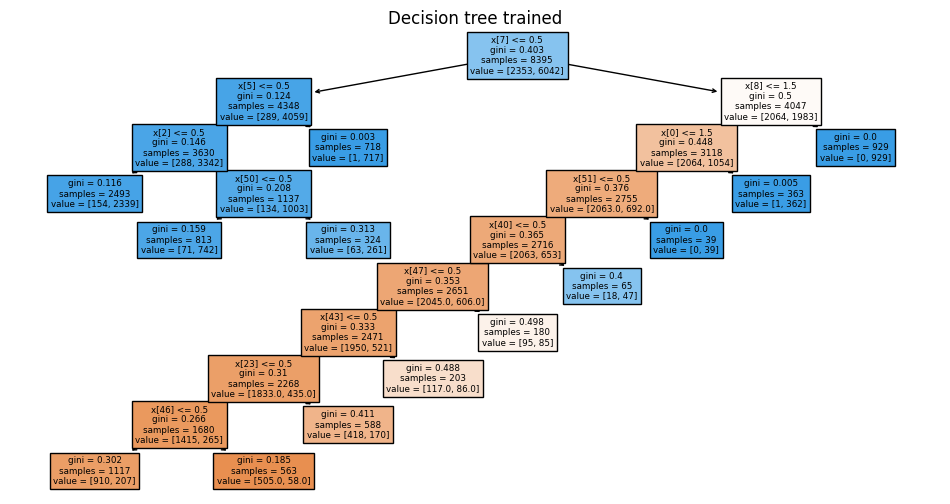

In [39]:
plt.figure(figsize=(12, 6))

plot_tree(CV_clf_tree.best_estimator_, filled=True)
plt.title("Decision tree trained")
plt.show()

In [40]:
print("Getting the relevants features:")

print()

for i, v in enumerate(CV_clf_tree.best_estimator_.feature_importances_):
    if v:
        print(f"X[{i}] = {notifications.columns[i]} ({v})")

Getting the relevants features:

X[0] = quant_instituicoes_atuando_local (0.18170821120426112)
X[2] = plano_emergencia_acionado (0.0024996356523950803)
X[5] = informacao_geografica (0.0037067958214518615)
X[7] = des_ocorrencia (0.4196973989602345)
X[8] = quant_tipos_danos_identificados (0.3192230910440615)
X[23] = uf_MA (0.007651637651397649)
X[40] = uf_TO (0.01578942131977822)
X[43] = origem_Duto (0.010193785462844537)
X[46] = origem_Indústria (0.0025804906514396227)
X[47] = origem_Outro(s) (0.011666398760670224)
X[50] = origem_Refinaria (0.0027054069578716835)
X[51] = origem_Rodovia (0.022577726513593965)


The regularization process allowed to increase the accuracy in the test when it got a little worse in training. Thus, the generalization becomes even greater when the errors in training and testing are very close.

In [41]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Best parameters: {CV_clf_tree.best_estimator_}")

print()
print(f"Ein = {(1 - CV_clf_tree.score(X_train, y_train))*100:.2f}%")
print(f"Eout = {(1 - CV_clf_tree.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_tree.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_tree.predict(X_test)))

Analyzing the results obtained with DecisionTreeClassifier:

Best parameters: DecisionTreeClassifier(ccp_alpha=0.0005734183216588914)

Ein = 10.89%
Eout = 11.15%

         h(x)=0  h(x)=+1
f(x)=0      869      129
f(x)=+1     272     2328

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       998
           1       0.95      0.90      0.92      2600

    accuracy                           0.89      3598
   macro avg       0.85      0.88      0.87      3598
weighted avg       0.90      0.89      0.89      3598



## SVM

Getting the VC dimension for Support Vector Machine assuming the data is linearly separable

$$D_{vc} = d+1$$

Using the default kernel of sklearn `kernel='rbf'` we know that finding VC dimension is non-trivial and RBF have infinite VC dimension but still work well in practice.

> **Note**: We verify that the size of the training set allows generalization.

In [42]:
d_vc = X.shape[1] + 1

print("VC dimension:", d_vc)
print("By the golden rule: N >=", d_vc*10)

VC dimension: 53
By the golden rule: N >= 530


Building a SVM with the training instance:

In [43]:
clf_svm = SVC()

clf_svm.fit(X_train,y_train)

SVC()

The results obtained allow us to infer that there was no overfitting.

> **Note**: The difference between Ein and Eout was low.

In [44]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"E_in = {(1 - clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - clf_svm.score(X_test, y_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

E_in = 10.89%
E_out = 11.15%

         h(x)=0  h(x)=+1
f(x)=0      869      129
f(x)=+1     272     2328

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       998
           1       0.95      0.90      0.92      2600

    accuracy                           0.89      3598
   macro avg       0.85      0.88      0.87      3598
weighted avg       0.90      0.89      0.89      3598



To try to get a better classifier we will use cross-validating and testing various parameterization combinations. The golden rule, where $K = \frac{N}{5}$, is applied in this process.

In [45]:
param_grid = {'C' : [1, 2, 5, 10],
              'gamma' : [0.1, 0.01, 1, 5]}

CV_clf_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)

CV_clf_svm.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 2, 5, 10], 'gamma': [0.1, 0.01, 1, 5]})

Better results were obtained after the regularization of the C and gamma parameters:
- The results obtained allow us to infer that there was no overfitting
- The difference between Ein and Eout was low
- As the Eout is smaller than the expected Eout, then generalization is guaranteed

In [46]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Best parameters: {CV_clf_svm.best_estimator_}")

print()
print(f"E_in = {(1 - CV_clf_svm.score(X_train, y_train))*100:.2f}%")
print(f"E_out = {(1 - CV_clf_svm.score(X_test, y_test))*100:.2f}%")
print(f"E[E_out_] <= {(len(CV_clf_svm.best_estimator_.support_vectors_) / len(X_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, CV_clf_svm.predict(X_test)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_test, CV_clf_svm.predict(X_test)))

Analyzing the results obtained with SupportVectorMachine:

Best parameters: SVC(C=1, gamma=0.1)

E_in = 10.89%
E_out = 11.15%
E[E_out_] <= 30.14%

         h(x)=0  h(x)=+1
f(x)=0      869      129
f(x)=+1     272     2328

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       998
           1       0.95      0.90      0.92      2600

    accuracy                           0.89      3598
   macro avg       0.85      0.88      0.87      3598
weighted avg       0.90      0.89      0.89      3598



## NN

Getting the maximum number of neurons for a single-layer network

$$n \leq \left \lfloor {\frac{{\lvert}DS{\rvert}-10}{10(d+2)}}  \right \rfloor$$

It is known that the VC dimension for a network with a single layer is

$$D_{vc} = [(d+1)n + (n+1)]$$

By the golden rule let's get the minimun value for examples:

$$N >= 10d_{VC}$$

> **Note**: As the training set has size 8395 the golden rule is satisfied.

In [47]:
DS = len(X_train)
d = X_train.shape[1]

n = int((DS-10) / (10*(d+2)))
d_vc = (d+1)*n + (n+1)

print(f"Number of neurons in the hidden layer: {n}")
print("VC dimension assuming use of all possible neurons:", d_vc)

Number of neurons in the hidden layer: 15
VC dimension assuming use of all possible neurons: 811


Auxiliary functions for building models (neural network with a single hidden layer):

In [48]:
def create_model(n, d):
    model = Sequential()

    model.add(Input(shape=(d,)))
    model.add(Dense(n, kernel_initializer='normal', activation='tanh'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    adam = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

Network configured based on information from the VC dimension and the golden rule:

In [49]:
clf_neural = create_model(n, d)

print(clf_neural.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │             795 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 811 (3.17 KB)

 Trainable params: 811 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

None


In [50]:
history = clf_neural.fit(X_train, y_train, epochs=500, batch_size=1024)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6158 - loss: 0.6539  
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.7144 - loss: 0.5360
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7710 - loss: 0.4495 
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8348 - loss: 0.4105 
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 235us/step - accuracy: 0.8644 - loss: 0.3911
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8804 - loss: 0.3869 
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step - accuracy: 0.8904 - loss: 0.3644
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8923 - loss: 0.3539 
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.8853 - loss: 0.3546
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.8873 - loss: 0.3444
Epoch 11/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8840 - loss: 0.3561 
Epoch 12/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 204us/step - accuracy: 0.89

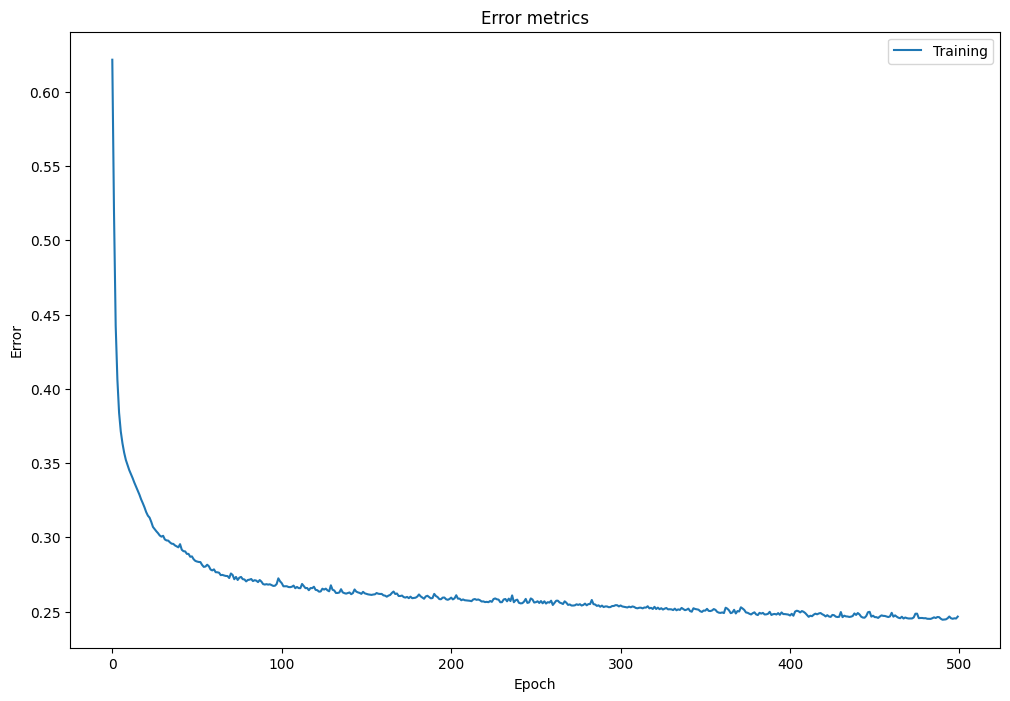

In [51]:
plt.figure(figsize=(12, 8))

plt.plot(history.history['loss'])

plt.title('Error metrics')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Training'])

plt.show()

In [52]:
pred_train = np.round(clf_neural.predict(X_train, verbose=0))
pred_test = np.round(clf_neural.predict(X_test, verbose=0))

print("Analyzing the results obtained with NeuralNetwork:")

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with NeuralNetwork:

E_in = 10.70%
E_out = 12.15%

         h(x)=0  h(x)=+1
f(x)=0      809      189
f(x)=+1     248     2352

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       998
           1       0.93      0.90      0.91      2600

    accuracy                           0.88      3598
   macro avg       0.85      0.86      0.85      3598
weighted avg       0.88      0.88      0.88      3598



During the construction of the ML model, it was tested using the ``batch_size`` as the size of the training set (using all the data) and it was verified that when decreasing this size the result improves by less than 1%.

In this way, the second highest power of 3 below the size of the training set ($2^{10}$) was chosen for the argument, this large value for the `batch_size` allowed us to considerably increase the number of epochs without compromising the efficiency of the algorithm (we used `epochs=500`).

The results obtained allow us to infer that there was no overfitting, as the difference between `Ein` and `Eout`. In this way, a more accurate analysis of the evolution of the model over time is not necessary.

In [53]:
def create_huge_model(n, d):
    model = Sequential()

    model.add(Input(shape=(d,)))
    model.add(Dense(2*n, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(2*n, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.01), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))

    adam = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

Training a network with two layers each with twice as many neurons allowed in the hidden layer:

> **Note**: The results are checked after applying the regularization process.

In [54]:
clf_neural = create_huge_model(n, d)

print(clf_neural.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 30)                  │           1,590 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,551 (9.96 KB)

 Trainable params: 2,551 (9.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = clf_neural.fit(X_train, y_train, validation_data=(X_test, y_test),
                         epochs=500, batch_size=512, callbacks=[es])

Epoch 1/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7111 - loss: 0.6506 - val_accuracy: 0.8088 - val_loss: 0.4805
Epoch 2/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8449 - loss: 0.4671 - val_accuracy: 0.8872 - val_loss: 0.4226
Epoch 3/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8859 - loss: 0.4242 - val_accuracy: 0.8780 - val_loss: 0.4122
Epoch 4/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8790 - loss: 0.4210 - val_accuracy: 0.8863 - val_loss: 0.4101
Epoch 5/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8852 - loss: 0.4145 - val_accuracy: 0.8824 - val_loss: 0.4079
Epoch 6/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8809 - loss: 0.4213 - val_accuracy: 0.8830 - val_loss: 0.4001
Epoch 7/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8846 - loss: 0.4112 - val_accuracy: 0.8863 - val_loss: 0.4010
Epoch 8/500
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8837 - loss: 0.4149 - val_accuracy: 0.8838 - 

In [56]:
pred_train = np.round(clf_neural.predict(X_train, verbose=0))
pred_test = np.round(clf_neural.predict(X_test, verbose=0))

print("Analyzing the results obtained with NeuralNetwork:")

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with NeuralNetwork:

E_in = 11.30%
E_out = 11.40%

         h(x)=0  h(x)=+1
f(x)=0      825      173
f(x)=+1     237     2363

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       998
           1       0.93      0.91      0.92      2600

    accuracy                           0.89      3598
   macro avg       0.85      0.87      0.86      3598
weighted avg       0.89      0.89      0.89      3598



The results allow us to infer that the addition of layers and neurons has no potential to improve the classification quality.

## CONCLUSION

During the elaboration of the project, we obtained the following classifiers.

In [57]:
clf_tree = DecisionTreeClassifier(ccp_alpha=CV_clf_tree.best_params_['ccp_alpha'])

clf_tree

DecisionTreeClassifier(ccp_alpha=0.0005734183216588914)

In [58]:
clf_svm = SVC(C=CV_clf_svm.best_params_['C'], gamma=CV_clf_svm.best_params_['gamma'])

clf_svm

SVC(C=1, gamma=0.1)

In [59]:
clf_neural = create_model(n, d)

clf_neural.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 15)                  │             795 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 811 (3.17 KB)

 Trainable params: 811 (3.17 KB)

 Non-trainable params: 0 (0.00 B)

Choosing the best model, trained in the previous phases, for the dataset using the train instance through a validation strategy for choosing models.

In [60]:
# Separating training data into training and validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

N_train, N_val = X_train.shape[0], X_val.shape[0]

print("Number of samples in training:", N_train)
print("Number of samples in validation:", N_val)

Number of samples in training: 6716
Number of samples in validation: 1679


In [61]:
clf_tree.fit(X_train, y_train)
eval_tree = 1 - clf_tree.score(X_val, y_val)

clf_svm.fit(X_train, y_train)
eval_svm = 1 - clf_svm.score(X_val, y_val)

clf_neural.fit(X_train, y_train, epochs=500, batch_size=2048, verbose=0)
eval_neural = 1 - accuracy_score(y_val, np.round(clf_neural.predict(X_val, verbose=0)))

print(f"Eval (decision tree classifier) = {eval_tree*100:.2f}%")
print(f"Eval (SVM) = {eval_svm*100:.2f}%")
print(f"Eval (neural network) = {eval_neural*100:.2f}%")

Eval (decision tree classifier) = 10.66%
Eval (SVM) = 10.66%
Eval (neural network) = 11.85%


Analyzing the best model (using as a criterion the lowest number of false negatives in the validation set):

In [62]:
names = ['DecisionTreeClassifier', 'SVM', 'NN']
models = [clf_tree, clf_svm, clf_neural]

best = np.argmin([confusion_matrix(y_val, models[0].predict(X_val))[1][0],
                  confusion_matrix(y_val, models[1].predict(X_val))[1][0],
                  confusion_matrix(y_val, np.round(models[2].predict(X_val, verbose=0)))[1][0]])

In [63]:
print('Analyzing the results obtained with the best model:', names[best])

if best == 2:
    pred_train = np.round(models[best].predict(X_train, verbose=0))
    pred_test = np.round(models[best].predict(X_test, verbose=0))
else:
    pred_train = models[best].predict(X_train)
    pred_test = models[best].predict(X_test)

print()
print(f"E_in = {(1 - accuracy_score(y_train, pred_train))*100:.2f}%")
print(f"E_out = {(1 - accuracy_score(y_test, pred_test))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_test, pred_test),
                  index=['f(x)=0', 'f(x)=+1'],
                  columns=['h(x)=0', 'h(x)=+1']))
print(f'\n{classification_report(y_test, pred_test)}')

Analyzing the results obtained with the best model: DecisionTreeClassifier

E_in = 10.94%
E_out = 11.15%

         h(x)=0  h(x)=+1
f(x)=0      869      129
f(x)=+1     272     2328

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       998
           1       0.95      0.90      0.92      2600

    accuracy                           0.89      3598
   macro avg       0.85      0.88      0.87      3598
weighted avg       0.90      0.89      0.89      3598



## DISCUSSION

In the context of the problem at hand, a false positive result would lead to the misuse of public resources. However, a false negative result could have disastrous consequences, as it would mean that a real environmental accident was overlooked, potentially resulting in the spread of forest fires or oil spills, for example. As such, addressing this issue is a key area for improvement in the model, as noted below.

In [64]:
confusion = confusion_matrix(y_test, pred_test)

print(f"Analyzing the results obtained with the best model: {names[best]}\n")

print(f"False positive = {confusion[0][1]}")
print(f"False negative = {confusion[1][0]}")

Analyzing the results obtained with the best model: DecisionTreeClassifier

False positive = 129
False negative = 272
